In [ ]:
!pip install duckdb
!pip install cassandra-sigv4
!pip install boto3

# Gen AI Disclosure

I used Colab autocomplete to generate code from commented prompts where marked (CAI). I used ChatGPT for a little help with some file management commands in the terminal.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb

In [2]:
# Setting up the database file
conn = duckdb.connect('healthcare.duckdb')

files = ["ADMISSIONS.csv","ICUSTAYS.csv","PATIENTS.csv","PROCEDURES_ICD.csv",
         "D_ICD_PROCEDURES.csv","DRGCODES.csv","PRESCRIPTIONS.csv"]

for file in files:
    data = pd.read_csv(f"Data/{file}")
    # (CAI) Convert Create Table query to import dataframe
    conn.sql(f"""
        CREATE TABLE {file.removesuffix(".csv")} AS SELECT * FROM data;
    """)

r = conn.sql("SHOW TABLES;")
print(r)
conn.close()

┌──────────────────┐
│       name       │
│     varchar      │
├──────────────────┤
│ ADMISSIONS       │
│ DRGCODES         │
│ D_ICD_PROCEDURES │
│ ICUSTAYS         │
│ PATIENTS         │
│ PRESCRIPTIONS    │
│ PROCEDURES_ICD   │
└──────────────────┘



## Analysis Questions

1. Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.

In [3]:
conn = duckdb.connect("healthcare.duckdb")

In [4]:
r = conn.sql("""
        SELECT ethnicity, drug AS drug_name, count(*) AS prescriptions
        FROM ADMISSIONS LEFT JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
        GROUP BY ethnicity, drug_name ORDER BY ethnicity, prescriptions DESC;
    """)
df = r.df()
df = df.drop_duplicates(subset=['ethnicity'], keep='first').reset_index(drop=True)
print("Most perscribed drugs by ethnicity:")
for _, row in df.iterrows():
    print(f"{row['ethnicity']}: {row['drug_name']}, {row['prescriptions']}")

df.to_csv("q1_sql.csv")

Most perscribed drugs by ethnicity:
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE: 5% Dextrose, 54
ASIAN: D5W, 27
BLACK/AFRICAN AMERICAN: Insulin, 60
HISPANIC OR LATINO: 5% Dextrose, 28
HISPANIC/LATINO - PUERTO RICAN: 0.9% Sodium Chloride, 1290
OTHER: NS, 11
UNABLE TO OBTAIN: 0.9% Sodium Chloride, 28
UNKNOWN/NOT SPECIFIED: D5W, 41
WHITE: Potassium Chloride, 508


2. Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.

In [5]:
procedures = conn.sql("""
    SELECT PATIENTS.subject_id AS subject_id, short_title, FLOOR((cast(admittime as date) - cast(dob as date)) / 365) AS age
    FROM PROCEDURES_ICD JOIN D_ICD_PROCEDURES ON PROCEDURES_ICD.icd9_code = D_ICD_PROCEDURES.icd9_code
    JOIN PATIENTS on PROCEDURES_ICD.subject_id = PATIENTS.subject_id
    JOIN ADMISSIONS on PROCEDURES_ICD.hadm_id = ADMISSIONS.hadm_id;
""").df()

def age_group(age):
    if age <= 19:
        return "<=19"
    elif age <= 49:
        return "20-49"
    elif age <= 79:
        return "50-79"
    else:
        return ">=80"

procedures['age_group'] = procedures['age'].apply(age_group)
procedures.drop(columns=['age'], inplace=True)

r = conn.sql("""
    SELECT age_group, short_title, count(*) AS n_procedures FROM procedures
    GROUP BY age_group, short_title ORDER BY age_group, n_procedures DESC;
""").df()

# (CAI) custom sort df
age_order = ["<=19", "20-49", "50-79", ">=80"]
r['age_group'] = pd.Categorical(r['age_group'], categories=age_order, ordered=True)

for group, df in r.groupby('age_group'):
    print(f"{group}:")
    prev = 0
    for i, row in df.reset_index(drop=True).iterrows():
        print(f"{row['short_title']}: {row['n_procedures']}")
        if i > 1 and prev != row['n_procedures']:
            break
        prev = row['n_procedures']
    print()

r.to_csv("q2_sql.csv")

<=19:
Venous cath NEC: 2
Temporary tracheostomy: 1
Packed cell transfusion: 1
Vertebral fx repair: 1
Percu endosc gastrostomy: 1
Skin closure NEC: 1
Closed bronchial biopsy: 1
Open reduc-int fix femur: 1
Entral infus nutrit sub: 1
Fus/refus 2-3 vertebrae: 1
Spinal tap: 1
Applic ext fix dev-femur: 1
Remove imp device-femur: 1
Incision of lung: 1
Atlas-axis fusion: 1
Ot cerv fusion post/post: 1
Cl fx reduc-femur: 1
Interruption vena cava: 1
Other skeletal traction: 1

20-49:
Venous cath NEC: 9
Entral infus nutrit sub: 7
Insert endotracheal tube: 6

50-79:
Venous cath NEC: 26
Entral infus nutrit sub: 22
Packed cell transfusion: 13

>=80:
Venous cath NEC: 19
Packed cell transfusion: 13
Insert endotracheal tube: 8



/tmp/ipykernel_350/1622220919.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df in r.groupby('age_group'):


3. How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?

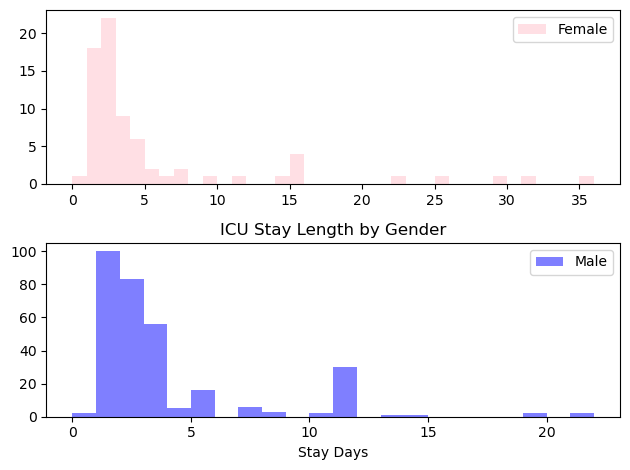

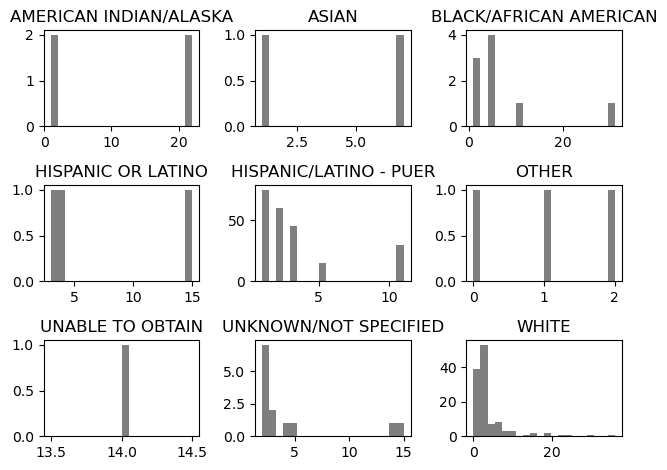




Number of patients who were admitted multiple times by gender/ethnicity:


gender  ethnicity                                               
M       WHITE                                                       20
F       WHITE                                                        8
M       HISPANIC/LATINO - PUERTO RICAN                               5
F       HISPANIC OR LATINO                                           2
M       AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE     2
F       UNKNOWN/NOT SPECIFIED                                        1
M       BLACK/AFRICAN AMERICAN                                       1
Name: count, dtype: int64

In [6]:
r = conn.sql("""
    SELECT ICUSTAYS.subject_id AS subject_id, gender, ethnicity, cast(outtime as date) - cast(intime as date) AS stay_days
    FROM ICUSTAYS JOIN ADMISSIONS ON ICUSTAYS.subject_id = ADMISSIONS.subject_id
    JOIN PATIENTS ON ICUSTAYS.subject_id = PATIENTS.subject_id ORDER BY subject_id;
""").df()

fig, ax = plt.subplots(2)
data = r[r['gender'] == 'F']['stay_days']
# (CAI) Plot histogram of stay_days in r grouped by gender (modified)
ax[0].hist(data, bins=max(data)-min(data), alpha=0.5, label='Female', color='pink')
ax[0].legend()
plt.title("ICU Stay Length by Gender")
data = r[r['gender'] == 'M']['stay_days']
ax[1].hist(data, bins=max(data)-min(data), alpha=0.5, label='Male', color='blue')
ax[1].legend()
plt.xlabel('Stay Days')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3,3)

for i, group in enumerate(r.groupby('ethnicity')):
    ax[i//3, i%3].hist(group[1]['stay_days'], bins=20, alpha=0.5, color='black')
    ax[i//3, i%3].set_title(group[0][:22])
plt.tight_layout()
plt.show()

r.to_csv("q3_sql.csv")

# Used CAI to understand the duplicated function
print("\n\n")
print("Number of patients who were admitted multiple times by gender/ethnicity:")
r[r.duplicated(subset=['subject_id'], keep=False)].drop_duplicates(keep='first')[['gender','ethnicity']].value_counts()

## Cassandra Tables

In [7]:
from cassandra.cluster import Cluster
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider
import boto3

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

/tmp/ipykernel_350/332746716.py:7: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


In [8]:
# authorization setup with SigV4
auth_provider = SigV4AuthProvider(boto_session)

In [9]:
#cluster setup 
cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider, 
                  port=9142)  # TLS only communicates on port 9142

In [10]:
session = cluster.connect()

Question 1

In [13]:
from cassandra.cluster import ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel

# Define execution profile with LOCAL_QUORUM
execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

# Cluster setup with correct profile
cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    port=9142,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

# establishing connection to Keyspace
session = cluster.connect()

In [89]:
session.set_keyspace('ryan_beam')

In [76]:
# session.execute("""
#     DROP TABLE IF EXISTS q1;
# """)

session.execute("""
    CREATE TABLE IF NOT EXISTS q1 (
    ethnicity TEXT,
    drug TEXT,
    prescriptions INT,
    PRIMARY KEY (ethnicity, drug)
);
""")

r = conn.sql("""
        SELECT ethnicity, drug, count(*) AS prescriptions
        FROM ADMISSIONS LEFT JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
        GROUP BY ethnicity, drug ORDER BY ethnicity, prescriptions DESC;
    """).df()

r = r.fillna("None")

for _, row in r.iterrows():
    session.execute("""
        INSERT INTO q1 (ethnicity, drug, prescriptions)
        VALUES (%s, %s, %s);
    """, (row["ethnicity"], row["drug"], row['prescriptions']))

import csv
rows = session.execute("SELECT * FROM q1")
with open("q1_cas.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ethnicity", "drug","prescriptions"])
    for row in rows:
        writer.writerow([row.ethnicity, row.drug, row.prescriptions])

data = pd.read_csv("q1_cas.csv")
data = data.sort_values(by="prescriptions", ascending=False)
data = data.drop_duplicates(subset=["ethnicity"])
data

,ethnicity,drug,prescriptions
805,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,1290
626,WHITE,Potassium Chloride,508
122,BLACK/AFRICAN AMERICAN,Insulin,60
1112,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,54
971,UNKNOWN/NOT SPECIFIED,D5W,41
1181,HISPANIC OR LATINO,5% Dextrose,28
1053,UNABLE TO OBTAIN,0.9% Sodium Chloride,28
754,ASIAN,D5W,27
38,OTHER,NS,11


In [77]:
# session.execute("""
#     DROP TABLE IF EXISTS q2;
# """)

session.execute("""
    CREATE TABLE IF NOT EXISTS q2 (
    subject_id TEXT,
    short_title TEXT,
    age_group TEXT,
    PRIMARY KEY (subject_id, short_title)
);
""")

procedures = conn.sql("""
    SELECT PATIENTS.subject_id AS subject_id, short_title, FLOOR((cast(admittime as date) - cast(dob as date)) / 365) AS age
    FROM PROCEDURES_ICD JOIN D_ICD_PROCEDURES ON PROCEDURES_ICD.icd9_code = D_ICD_PROCEDURES.icd9_code
    JOIN PATIENTS on PROCEDURES_ICD.subject_id = PATIENTS.subject_id
    JOIN ADMISSIONS on PROCEDURES_ICD.hadm_id = ADMISSIONS.hadm_id;
""").df()

def age_group(age):
    if age <= 19:
        return "<=19"
    elif age <= 49:
        return "20-49"
    elif age <= 79:
        return "50-79"
    else:
        return ">=80"

procedures['age_group'] = procedures['age'].apply(age_group)
procedures.drop(columns=['age'], inplace=True)

for _, row in procedures.iterrows():
    session.execute("""
        INSERT INTO q2 (subject_id, short_title, age_group)
        VALUES (%s, %s, %s);
    """, (str(row["subject_id"]), row["short_title"], row['age_group']))

import csv
rows = session.execute("SELECT * FROM q2")
with open("q2_cas.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["subject_id", "short_title","age_group"])
    for row in rows:
        writer.writerow([row.subject_id, row.short_title, row.age_group])

In [90]:
session.execute("""
    DROP TABLE IF EXISTS q3;
""")

session.execute("""
    CREATE TABLE IF NOT EXISTS q3 (
    subject_id TEXT,
    gender TEXT,
    ethnicity TEXT,
    stay_days TEXT,
    PRIMARY KEY (subject_id, gender, ethnicity)
);
""")

r = conn.sql("""
    SELECT ICUSTAYS.subject_id AS subject_id, gender, ethnicity, cast(outtime as date) - cast(intime as date) AS stay_days
    FROM ICUSTAYS JOIN ADMISSIONS ON ICUSTAYS.subject_id = ADMISSIONS.subject_id
    JOIN PATIENTS ON ICUSTAYS.subject_id = PATIENTS.subject_id ORDER BY subject_id;
""").df()

for _, row in r.iterrows():
    session.execute("""
        INSERT INTO q3 (subject_id, gender, ethnicity, stay_days)
        VALUES (%s, %s, %s, %s);
    """, (str(row["subject_id"]), row["gender"], row['ethnicity'], str(row['stay_days'])))

import csv
rows = session.execute("SELECT * FROM q3")
with open("q3_cas.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["subject_id", "gender","ethnicity","stay_days"])
    for row in rows:
        writer.writerow([row.subject_id, row.gender, row.ethnicity, row.stay_days])

InvalidRequest: Error from server: code=2200 [Invalid query] message="unconfigured table ryan_beam.q3"

In [ ]:
conn.close()